# 1. Building basic QNN example
## 1.a Construct a 2-qubit basic quantum  neural network
> 2011.00027 논문을 참고하거나, 자유롭게 FeatureMap과 Ansatz 사용

In [4]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

def FeatureMapBuilder(num_features, reps):
    feature_map = ZZFeatureMap(
        feature_dimension=num_features,
        reps=reps,
    )
    return feature_map

def AnsatzBuilder(num_qubits, reps):
    ansatz = TwoLocal(
        num_qubits=num_qubits,
        rotation_blocks='ry',
        entanglement_blocks='cx',
        entanglement='full', 
        reps=reps, 
        insert_barriers=True
    )
    return ansatz

from qiskit_machine_learning.circuit.library import QNNCircuit

def QnnModelCircuitBuilder(num_qubits, reps_feature_map, reps_ansatz):
    feature_map = FeatureMapBuilder(num_qubits, reps_feature_map)
    ansatz = AnsatzBuilder(num_qubits, reps_ansatz)

    qnn_circuit = QNNCircuit(
        num_qubits=num_qubits,
        feature_map=feature_map,
        ansatz=ansatz
    )
    return qnn_circuit

- ZZFeatureMap 기반 FeatureMap 생성 함수
- TwoLocal 회로 기반 Ansatz 생성 함수
- QNN circuit 생성 함수


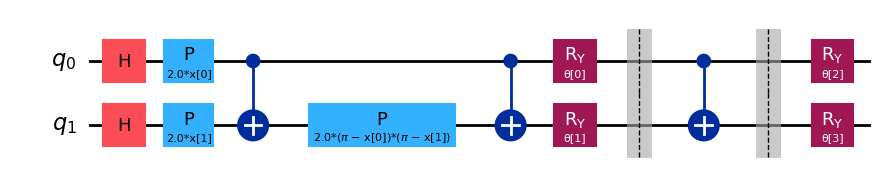

In [5]:
qnn_circuit = QnnModelCircuitBuilder(
    num_qubits=2,
    reps_feature_map=1,
    reps_ansatz=1
)

qnn_circuit.decompose().draw("mpl")

## 1.b. Compute Effective Dimension of the Model
> Training data의 Distribution에 대한 dependence를 찾기
- by varying the input data

In [6]:
from qiskit.primitives import StatevectorSampler as Sampler
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN

In [7]:
sampler = Sampler()
#Sampler 기반 QNN인 samplerQNN 정의
qnn = SamplerQNN(
    circuit=qnn_circuit,
    input_params=qnn_circuit.feature_map.parameters,
    weight_params=qnn_circuit.ansatz.parameters,
    sampler=sampler,
)

qnn.input_params
qnn.weight_params

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3])]

In [8]:
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
def plot_effective_dimension(effective_dimension):
    global_ed = effective_dimension

    global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

    d = qnn.num_weights
    
    print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
    print(
        "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
    )

    # global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)
    # print("Effective dimension: {}".format(global_eff_dim_1))

    # print("Number of weights: {}".format(d))
    # plt.plot(n, np.array(global_eff_dim_1) / d)
    # plt.xlabel("Number of data")
    # plt.ylabel("Normalized GLOBAL effective dimension")
    # plt.show()

In [9]:
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

# print(input_samples)
# from sklearn.preprocessing import MinMaxScaler
# tmp_input_samples = MinMaxScaler().fit_transform(input_samples)
# print(tmp_input_samples)

qnn_ed = EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples
    )
plot_effective_dimension(qnn_ed)

Starting: Monte Carlo Sampling
Finisehd: Monte Carlo Sampling
Starting: Fisher Information
model_outputs에 0이 없음
Finished: Fisher Information
Starting: Normalize
Finished: Normalize
Starting: Effective Dimension
Finished: Effective Dimension
Data size: 5000, global effective dimension: 3.9435
Number of weights: 4, normalized effective dimension: 0.9859


qnn의 output shape은 무조건 1행짜리 행열
2큐비트면 4개 확률분포, 3큐비트면 8개

In [10]:
# from qiskit_machine_learning.neural_networks import NeuralNetwork
# from typing import Tuple, Any, List, Union
# import time
# import logging
# import pandas as pd
# from IPython.display import display, Latex
# from scipy.special import logsumexp

# logger = logging.getLogger(__name__)

# class SQuAI_EffectiveDimension:
#     def __init__(
#             self,
#             qnn: NeuralNetwork,
#             input_samples: np.ndarray,
#             weight_samples: np.ndarray,
#             approx_epsilon: float = 1e-10
#     ) -> None:
#         self._weight_samples = weight_samples
#         self._input_samples = input_samples
#         self._num_weight_samples = len(self._weight_samples)
#         self._num_input_samples = len(self._input_samples)
#         self._model = qnn
#         self._epsilon = approx_epsilon
#         self.fisher_information_matrix: np.ndarray = None
#         self.normalized_fisher_information_matrix: np.ndarray = None
#         self.effective_dimensions: np.ndarray = None
#         self.dataset_sizes = None
#         self.gamma = None
#         ## For SuperCalculation
#         self._compressed_weight_samples:np.ndarray = np.empty((0, self._model.num_weights))
#         self._num_compressed_weight_samples:int = 0
    
#     def run_monte_carlo(self) -> Tuple[np.ndarray, np.ndarray]:
#         # 가중치 마다의 (num_weights) gradient를 구해야하기에 3차원 배
#         grads: Any = np.zeros(
#             (
#                 self._num_input_samples * self._num_weight_samples,
#                 self._model.output_shape[0],
#                 self._model.num_weights,
#             )
#         )
#         # 입력 샘플 수 * 가중치 샘플 수 만큼의 조합 만큼의 행
#         # output_shape 즉, 3큐비트면 8개의 
#         outputs: Any = np.zeros(
#             (
#                 self._num_input_samples * self._num_weight_samples,
#                 self._model.output_shape[0]
#             )
#         )

#         # enumerate 함수 사용해서, index를 붙여가면서 가중치 조합 (세타1, 세타2, ...세타 n)을 사용할 수 있음 
#         for i, param_set in enumerate(self._weight_samples):
#             t_before_forward = time.time()
#             forward_pass = np.asarray(
#                 self._model.forward(input_data=self._input_samples, weights=param_set)
#             )
#             t_after_forward = time.time()

#             backward_pass = np.asarray(
#                 self._model.backward(input_data=self._input_samples, weights=param_set)[1]
#             )
#             t_after_backward = time.time()

#             t_forward = t_after_forward - t_before_forward
#             t_backward = t_after_backward - t_after_forward

#             # forward, backward 시간 분석 -> 병목 확인 
#             logger.debug(
#                 "Weight sample: %d, forward time: %.3f (s), backward time: %.3f (s)",
#                 i,
#                 t_forward,
#                 t_backward,
#             )

#             grads[self._num_input_samples * i : self._num_input_samples * (i + 1)] = backward_pass
#             outputs[self._num_input_samples * i : self._num_input_samples * (i + 1)] = forward_pass

#         return grads, outputs

#     def buildFIM(
#             self,
#     ) -> np.ndarray:
#         gradients, model_outputs = self.run_monte_carlo()
        
#         if model_outputs.ndim < gradients.ndim:
#             model_outputs = np.expand_dims(model_outputs, axis=2)

#         mask = model_outputs == 0
#         mask_squeezed = np.squeeze(mask)
#         if np.any(mask_squeezed):
#             rows, cols = np.where(mask_squeezed)
#             model_outputs = model_outputs + (mask * self._epsilon)
        
#         gradvectors = np.sqrt(model_outputs) * gradients / model_outputs

#         fisher_information = np.einsum("ijk,lji->ikl", gradvectors, gradvectors.T)

#         self.fisher_information_matrix = fisher_information
            
#         # if (normalization == False):
#             # return fisher_information
#         # else:
#         fisher_trace = np.trace(np.average(fisher_information, axis = 0))

        
#         fisher_avg = np.average(
#             np.reshape(
#                 fisher_information,
#                 (
#                     self._num_weight_samples,
#                     self._num_input_samples,
#                     self._model.num_weights,
#                     self._model.num_weights,
#                 ),
#             ),
#             axis=1,
#         )
        
#         normalized_fisher = self._model.num_weights * fisher_avg / fisher_trace
#         # print(normalized_fisher.shape)
#         self.normalized_fisher_information_matrix = normalized_fisher
#         # return normalized_fisher
    
#     def printFIM(
#             self,
#             normalized: bool = True
#             ) -> None:
#         if (normalized): fim = self.normalized_fisher_information_matrix
#         else : self.fisher_information_matrix

#         # fim_avg = np.mean(fim, axis=-1) if fim.ndim == 3 else fim

#         np.set_printoptions(precision=4, suppress=True)
#         print("Fisher Information Matrix:")
#         print(fim)

#         # 또는 pandas DataFrame으로 보기
#         # display(pd.DataFrame(fim))

#     # def display_fim_latex(
#     #         fim: np.ndarray,
#     #         precision: int = 4
#     #         ) -> None:
#     #     num_matrices = fim.shape[2] if fim.ndim == 3 else 1
#     #     fim_list = [fim[:, :, i] for i in range(num_matrices)] if fim.ndim == 3 else [fim]

#     #     for idx, matrix in enumerate(fim_list):
#     #         # Format each element
#     #         latex_rows = []
#     #         for row in matrix:
#     #             latex_row = " & ".join([f"{elem:.{precision}f}" for elem in row])
#     #             latex_rows.append(latex_row)
#     #         latex_matrix = "\\\\\n".join(latex_rows)

#     #         # Wrap in LaTeX matrix syntax
#     #         latex_code = (
#     #             f"\\textbf{{Fisher Information Matrix \\#{idx}}} \\\\\n"
#     #             "\\[\n"
#     #             "\\begin{bmatrix}\n"
#     #             f"{latex_matrix}\n"
#     #             "\\end{bmatrix}\n"
#     #             "\\]\n"
#     #         )
#     #         display(Latex(latex_code))

#     def display_all_fims_latex(
#             self,
#             precision: int = 4,
#             normalized: bool = True
#             ) -> None:
        
#         if (normalized): fim = self.normalized_fisher_information_matrix
#         else : fim = self.fisher_information_matrix
        
#         num_fims = fim.shape[0]

#         for idx in range(num_fims):
#             onefim = fim[idx, :, :]

#             # 라텍스 행 생성
#             latex_rows = []
#             for row in onefim:
#                 row_str = " & ".join([f"{elem:.{precision}f}" for elem in row])
#                 latex_rows.append(row_str)
#             latex_matrix = "\\\\\n".join(latex_rows)

#             # LaTeX 코드 구성
#             latex_code = (
#                 f"\\textbf{{Fisher Information Matrix \\#{idx}}} \\\\\n"
#                 "\\[\n"
#                 "\\begin{bmatrix}\n"
#                 f"{latex_matrix}\n"
#                 "\\end{bmatrix}\n"
#                 "\\]\n"
#             )

#             display(Latex(latex_code))


#     def calculateEffectiveDimension(
#         self,
#         dataset_size: Union[List[int], np.ndarray, int],
#         gamma: Union[List[float], np.ndarray, float] = 1,
#     ) -> np.ndarray:
#         dataset_size = np.atleast_1d(dataset_size).astype(np.float64)
#         gamma = np.atleast_1d(gamma).astype(np.float64)
#         self.dataset_sizes = dataset_size
#         self.gamma = gamma

#         fisher = self.normalized_fisher_information_matrix  # (S, D, D)
#         assert fisher is not None, "normalized_fisher_information_matrix is not set"
#         S, D = fisher.shape[0], fisher.shape[1]

#         fisher_exp = fisher[np.newaxis, np.newaxis, :, :, :]
#         n_exp = dataset_size[:, np.newaxis, np.newaxis, np.newaxis]
#         g_exp = gamma[np.newaxis, :, np.newaxis, np.newaxis]

#         # scale factor
#         with np.errstate(divide='ignore', invalid='ignore'):
#             denom_term = np.log(n_exp)
#             scale = (n_exp * g_exp) / (2 * np.pi * denom_term)
#             scale = np.where(np.isfinite(scale), scale, 0.0)

#         scale = scale[:, :, np.newaxis, :, :]
#         f_mod = fisher_exp * scale
#         I = np.eye(D)[np.newaxis, np.newaxis, np.newaxis, :, :]
#         one_plus_fmod = I + f_mod

#         # logdet with safe handling
#         sign, logdet = np.linalg.slogdet(one_plus_fmod)
#         # Optional: mask very large/invalid logdets
#         logdet = np.where(np.isfinite(logdet), logdet, np.nan)  # or 0.0
#         dets_div = logdet / 2

#         logsum = logsumexp(dets_div, axis=2, b=np.isfinite(dets_div).astype(float))
#         denom = np.log(dataset_size / (2 * np.pi * np.log(dataset_size)))
#         denom = np.where(np.isfinite(denom), denom, np.nan)[:, np.newaxis]

#         effective_dims = 2 * (logsum - np.log(S)) / denom
#         self.effective_dimensions = effective_dims

#         return effective_dims
    
        
#     def display_effective_dim_latex_table(
#             self,
#             precision: int = 4
#     ):
#         """
#         Display effective dimension result as a LaTeX table.

#         Args:
#             effective_dims: 2D array of shape (len(dataset_sizes), len(gammas))
#             dataset_sizes: list or array of dataset sizes (rows)
#             gammas: list or array of gamma values (columns)
#             precision: number of decimal places for table values
#         """
#         dataset_sizes = np.atleast_1d(self.dataset_sizes)
#         gammas = np.atleast_1d(self.gamma)

#         # assert effective_dims.shape == (len(dataset_sizes), len(gammas)), "Shape mismatch!"

#         # 헤더 구성
#         col_headers = " & " + " & ".join([f"\\gamma={g}" for g in gammas]) + " \\\\"
#         latex_rows = [col_headers]

#         # 나머지 행
#         for i, n in enumerate(dataset_sizes):
#             row_values = " & ".join([f"{val:.{precision}f}" for val in self.effective_dimensions[i]])
#             row = f"n={n} & {row_values} \\\\"
#             latex_rows.append(row)

#         latex_body = "\n".join(latex_rows)

#         latex_code = (
#             "\\[\n"
#             "\\begin{array}{" + "c" * (len(gammas) + 1) + "}\n"
#             f"{latex_body}\n"
#             "\\end{array}\n"
#             "\\]"
#         )

#         display(Latex(latex_code))



#     # 최대 LED 가지는 sample 하나를 반환 
#     def maximum_local_effective_dimension_sample(
#             self,
#             target_weight_sample: np.ndarray
#     ):
#         local_effective_dimensions = []
#         for weight_sample in target_weight_sample:
#             # print(f"weight_sample {weight_sample}")
#             weight_sample = np.asarray(weight_sample).reshape(1, -1)
#             self._weight_samples = weight_sample
#             self._num_weight_samples = len(weight_sample)
#             self.buildFIM()
#             local_effective_dimensions.append(self.calculateEffectiveDimension(dataset_size=100000, gamma=0.5))

#         maximum_led = max(local_effective_dimensions)
#         max_idx = local_effective_dimensions.index(maximum_led)
#         return target_weight_sample[max_idx]

#     # Sample을 받고, 그 Sample 각 weight 값에 대해 상한, 하한 값을 만들어 반환 
#     def weight_value_constrainer(
#             self,
#             target_sample: np.ndarray,
#             shrink: float,
#     ) -> List[Tuple[float, float]]:
#         half = shrink / 2

#         bounds = []
#         for val in target_sample:
#             lower = max(0.0, val - half)
#             upper = min(1.0, val + half)
#             bounds.append((upper, lower))

#         return bounds

#     def generate_local_weight_samples(
#             self,
#             bounds: List[Tuple[float, float]],
#             num_new_sample: int
#     ) -> np.ndarray:
#         print("Generating local weight samples")
#         upper = np.array([b[0] for b in bounds])
#         lower = np.array([b[1] for b in bounds])
        
#         new_weight_sample = algorithm_globals.random.uniform(
#             low=lower,
#             high=upper,
#             size=(num_new_sample, self._model.num_weights)
#         )
#         self._compressed_weight_samples = np.concatenate([self._compressed_weight_samples, new_weight_sample], axis=0)
#         print(f"### Newly generated samples: {new_weight_sample}")
#         print(f"### Number of new generated samples: {len(new_weight_sample)}")
#         # print(f"### Tracking compress weight samples: {self._compressed_weight_samples}")
#         self._num_compressed_weight_samples += len(new_weight_sample)
#         return new_weight_sample

#     def compress_weight_samples(
#             self,
#     ) -> np.ndarray:
#         print("### Compressing weight samples")
#         num_each_weight_samples = self._num_weight_samples
#         new_boundary_factor = self._num_weight_samples 
#         # 처음 입력이 들어왔을 때는, 0과 1 사이의 값에서 random 하게 N^{1/파라미터 수} 만큼 뽑기 -> 그냥 무작위로 줄이기
#         bound = [(1, 0)]
#         # print(f"original N{N}")
#         while True:
#             num_each_weight_samples = int(num_each_weight_samples ** (1 / self._model.num_weights)) # 차원 만큼의 제곱근 한 것 만큼의 Sample로 대표 추정 
            
#             new_weight_sample = self.generate_local_weight_samples(bounds = bound, num_new_sample = num_each_weight_samples)
#             # 새로운 weight 들 중 LED 최대값을 가지는 Sample
#             max_sample = self.maximum_local_effective_dimension_sample(new_weight_sample)
            
#             new_boundary_factor = new_boundary_factor ** (1 / self._model.num_weights)
#             # upper, lower 값, 새로운 sample들 중 최대 LED 만드는 sample로 uppper, lower update
#             bound = self.weight_value_constrainer(target_sample=max_sample, shrink = new_boundary_factor)
#             if num_each_weight_samples == 1:
#                 self.generate_local_weight_samples(bounds = bound, num_new_sample = num_each_weight_samples)
#                 break

#     def super_calculate_effective_dimension(
#             self,
#             dataset_size: Union[List[int], np.ndarray, int],
#             gamma: Union[List[float], np.ndarray, float] = 1,
#     ) -> np.ndarray:
#         self.compress_weight_samples()
#         self._weight_samples = self.compress_weight_samples
#         self._num_weight_samples = self._num_compressed_weight_samples
#         self.calculateEffectiveDimension(dataset_size=dataset_size, gamma=gamma)

In [11]:
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

# print(input_samples)
# from sklearn.preprocessing import MinMaxScaler
# tmp_input_samples = MinMaxScaler().fit_transform(input_samples)
# print(tmp_input_samples)

qnn_ed = EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples
    )
plot_effective_dimension(qnn_ed)


Starting: Monte Carlo Sampling
Finisehd: Monte Carlo Sampling
Starting: Fisher Information
model_outputs == 0인 인덱스:
 - 위치 [42, 2]:
   → gradient = [ 0.00097656 -0.00097656  0.01416016 -0.01806641]
Finished: Fisher Information
Starting: Normalize
Finished: Normalize
Starting: Effective Dimension
Finished: Effective Dimension
Data size: 5000, global effective dimension: 0.8611
Number of weights: 4, normalized effective dimension: 0.2153


In [12]:

def plot_effective_dimension(effective_dimension):
    global_ed = effective_dimension

    global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

    d = qnn.num_weights
    
    print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
    print(
        "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
    )

    # global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)
    # print("Effective dimension: {}".format(global_eff_dim_1))

    # print("Number of weights: {}".format(d))
    # plt.plot(n, np.array(global_eff_dim_1) / d)
    # plt.xlabel("Number of data")
    # plt.ylabel("Normalized GLOBAL effective dimension")
    # plt.show()

In [13]:
# input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))
weight_samples

array([[0.3500518 , 0.95516767, 0.68931489, 0.92591532],
       [0.04064645, 0.29054348, 0.79570884, 0.68317849],
       [0.53619889, 0.87272715, 0.90127789, 0.36431388],
       [0.55713429, 0.77889123, 0.92059393, 0.9966184 ],
       [0.66222495, 0.7172724 , 0.65114481, 0.73872335],
       [0.48811579, 0.6396639 , 0.08457492, 0.54364345],
       [0.43336367, 0.58555597, 0.60586143, 0.0117928 ],
       [0.78767596, 0.52880616, 0.73771065, 0.01065026],
       [0.27000529, 0.93296628, 0.73885756, 0.28516157],
       [0.88214601, 0.99232991, 0.38023007, 0.25125895]])

In [14]:
num_samples = 100
input_samples = algorithm_globals.random.normal(0, 1, size=(num_samples, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(num_samples, qnn.num_weights))

effective_dimension = SQuAI_EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples,
)
effective_dimension.buildFIM()
# effective_dimension.printFIM()
print(effective_dimension.fisher_information_matrix.shape)
# effective_dimension.display_all_fims_latex(precision=4)
# effective_dimension.printFIM()

n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

effective_dimension.calculateEffectiveDimension(dataset_size=n, gamma=gamma)
effective_dimension.display_effective_dim_latex_table()

NameError: name 'SQuAI_EffectiveDimension' is not defined

In [ ]:
num_samples = 30

input_samples = algorithm_globals.random.normal(0, 1, size=(30, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(num_samples, qnn.num_weights))

effective_dimension = SQuAI_EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples,
)
effective_dimension.super_calculate_effective_dimension(dataset_size=n)

effective_dimension.display_effective_dim_latex_table()

### Compressing weight samples
Generating local weight samples
### Newly generated samples: [[0.3318 0.853  0.1344 0.6027]
 [0.0693 0.0912 0.8231 0.8262]]
### Number of new generated samples: 2
Generating local weight samples
### Newly generated samples: [[0.4154 0.2458 0.1956 0.348 ]]
### Number of new generated samples: 1
Generating local weight samples
### Newly generated samples: [[0.4755 0.5581 0.0118 0.5766]]
### Number of new generated samples: 1


<IPython.core.display.Latex object>

In [ ]:
effective_dimension_10000 = effective_dimension

In [ ]:
effective_dimension_10000.display_effective_dim_latex_table()
effective_dimension_10000._compressed_weight_samples

<IPython.core.display.Latex object>

array([[0.8049, 0.3781, 0.6844, 0.4946],
       [0.7009, 0.4669, 0.052 , 0.847 ],
       [0.506 , 0.6953, 0.3788, 0.7132],
       [0.6946, 0.9108, 0.4777, 0.5048],
       [0.3852, 0.1883, 0.3517, 0.636 ],
       [0.265 , 0.0616, 0.4212, 0.0112],
       [0.1067, 0.415 , 0.5149, 0.2116],
       [0.684 , 0.4589, 0.1056, 0.1458],
       [0.1899, 0.3022, 0.5199, 0.5855],
       [0.0552, 0.6844, 0.2701, 0.8   ],
       [0.4407, 0.7736, 0.5079, 0.3631],
       [0.9776, 0.3964, 0.7212, 0.8117]])

In [ ]:
# for weight in weight_samples:
    # print(f"weight: {weight}")

print("#############")
for weight in effective_dimension._compressed_weight_samples:
    print(f"weight: {weight}")

print(f"compressed_weight_num: {effective_dimension._num_compressed_weight_samples}")

#############
weight: [0.0954 0.567  0.8617 0.6652]
weight: [0.2938 0.0488 0.3834 0.4056]
weight: [0.1912 0.7218 0.4875 0.4508]
weight: [0.7732 0.7185 0.5278 0.4566]
weight: [0.933  0.9096 0.8544 0.5276]
weight: [0.2511 0.7069 0.3749 0.4889]
weight: [0.7341 0.0807 0.2149 0.3145]
compressed_weight_num: 7


In [45]:
from qiskit_machine_learning.neural_networks import NeuralNetwork
from typing import Tuple, Any, List, Union
import time
import logging
import pandas as pd
from IPython.display import display, Latex
from scipy.special import logsumexp

logger = logging.getLogger(__name__)

class SQuAI_EffectiveDimension:
    def __init__(
            self,
            qnn: NeuralNetwork,
            input_samples: np.ndarray,
            weight_samples: np.ndarray,
            approx_epsilon: float = 1e-10
    ) -> None:
        self._weight_samples = weight_samples
        self._input_samples = input_samples
        self._num_weight_samples = len(self._weight_samples)
        self._num_input_samples = len(self._input_samples)
        self._model = qnn
        self._epsilon = approx_epsilon
        self.fisher_information_matrix: np.ndarray = None
        self.normalized_fisher_information_matrix: np.ndarray = None
        self.effective_dimensions: np.ndarray = None
        self.dataset_sizes = None
        self.gamma = None
        ## For SuperCalculation
        self._compressed_weight_samples:np.ndarray = np.empty((0, self._model.num_weights))
        self._num_compressed_weight_samples:int = 0
    
    def run_monte_carlo(self) -> Tuple[np.ndarray, np.ndarray]:
        # 가중치 마다의 (num_weights) gradient를 구해야하기에 3차원 배
        grads: Any = np.zeros(
            (
                self._num_input_samples * self._num_weight_samples,
                self._model.output_shape[0],
                self._model.num_weights,
            )
        )
        # 입력 샘플 수 * 가중치 샘플 수 만큼의 조합 만큼의 행
        # output_shape 즉, 3큐비트면 8개의 
        outputs: Any = np.zeros(
            (
                self._num_input_samples * self._num_weight_samples,
                self._model.output_shape[0]
            )
        )

        # enumerate 함수 사용해서, index를 붙여가면서 가중치 조합 (세타1, 세타2, ...세타 n)을 사용할 수 있음 
        for i, param_set in enumerate(self._weight_samples):
            t_before_forward = time.time()
            forward_pass = np.asarray(
                self._model.forward(input_data=self._input_samples, weights=param_set)
            )
            t_after_forward = time.time()

            backward_pass = np.asarray(
                self._model.backward(input_data=self._input_samples, weights=param_set)[1]
            )
            t_after_backward = time.time()

            t_forward = t_after_forward - t_before_forward
            t_backward = t_after_backward - t_after_forward

            # forward, backward 시간 분석 -> 병목 확인 
            logger.debug(
                "Weight sample: %d, forward time: %.3f (s), backward time: %.3f (s)",
                i,
                t_forward,
                t_backward,
            )

            grads[self._num_input_samples * i : self._num_input_samples * (i + 1)] = backward_pass
            outputs[self._num_input_samples * i : self._num_input_samples * (i + 1)] = forward_pass

        return grads, outputs

    def buildFIM(
            self,
    ) -> np.ndarray:
        gradients, model_outputs = self.run_monte_carlo()
        
        if model_outputs.ndim < gradients.ndim:
            model_outputs = np.expand_dims(model_outputs, axis=2)

        mask = model_outputs == 0
        mask_squeezed = np.squeeze(mask)
        if np.any(mask_squeezed):
            rows, cols = np.where(mask_squeezed)
            model_outputs = model_outputs + (mask * self._epsilon)
        
        gradvectors = np.sqrt(model_outputs) * gradients / model_outputs

        fisher_information = np.einsum("ijk,lji->ikl", gradvectors, gradvectors.T)

        self.fisher_information_matrix = fisher_information
            
        # if (normalization == False):
            # return fisher_information
        # else:
        fisher_trace = np.trace(np.average(fisher_information, axis = 0))

        
        fisher_avg = np.average(
            np.reshape(
                fisher_information,
                (
                    self._num_weight_samples,
                    self._num_input_samples,
                    self._model.num_weights,
                    self._model.num_weights,
                ),
            ),
            axis=1,
        )
        
        normalized_fisher = self._model.num_weights * fisher_avg / fisher_trace
        # print(normalized_fisher.shape)
        self.normalized_fisher_information_matrix = normalized_fisher
        # return normalized_fisher
    
    def printFIM(
            self,
            normalized: bool = True
            ) -> None:
        if (normalized): fim = self.normalized_fisher_information_matrix
        else : self.fisher_information_matrix

        # fim_avg = np.mean(fim, axis=-1) if fim.ndim == 3 else fim

        np.set_printoptions(precision=4, suppress=True)
        print("Fisher Information Matrix:")
        print(fim)

        # 또는 pandas DataFrame으로 보기
        # display(pd.DataFrame(fim))

    # def display_fim_latex(
    #         fim: np.ndarray,
    #         precision: int = 4
    #         ) -> None:
    #     num_matrices = fim.shape[2] if fim.ndim == 3 else 1
    #     fim_list = [fim[:, :, i] for i in range(num_matrices)] if fim.ndim == 3 else [fim]

    #     for idx, matrix in enumerate(fim_list):
    #         # Format each element
    #         latex_rows = []
    #         for row in matrix:
    #             latex_row = " & ".join([f"{elem:.{precision}f}" for elem in row])
    #             latex_rows.append(latex_row)
    #         latex_matrix = "\\\\\n".join(latex_rows)

    #         # Wrap in LaTeX matrix syntax
    #         latex_code = (
    #             f"\\textbf{{Fisher Information Matrix \\#{idx}}} \\\\\n"
    #             "\\[\n"
    #             "\\begin{bmatrix}\n"
    #             f"{latex_matrix}\n"
    #             "\\end{bmatrix}\n"
    #             "\\]\n"
    #         )
    #         display(Latex(latex_code))

    def display_all_fims_latex(
            self,
            precision: int = 4,
            normalized: bool = True
            ) -> None:
        
        if (normalized): fim = self.normalized_fisher_information_matrix
        else : fim = self.fisher_information_matrix
        
        num_fims = fim.shape[0]

        for idx in range(num_fims):
            onefim = fim[idx, :, :]

            # 라텍스 행 생성
            latex_rows = []
            for row in onefim:
                row_str = " & ".join([f"{elem:.{precision}f}" for elem in row])
                latex_rows.append(row_str)
            latex_matrix = "\\\\\n".join(latex_rows)

            # LaTeX 코드 구성
            latex_code = (
                f"\\textbf{{Fisher Information Matrix \\#{idx}}} \\\\\n"
                "\\[\n"
                "\\begin{bmatrix}\n"
                f"{latex_matrix}\n"
                "\\end{bmatrix}\n"
                "\\]\n"
            )

            display(Latex(latex_code))


    def calculateEffectiveDimension(
        self,
        dataset_size: Union[List[int], np.ndarray, int],
        gamma: Union[List[float], np.ndarray, float] = 1,
    ) -> np.ndarray:
        dataset_size = np.atleast_1d(dataset_size).astype(np.float64)
        gamma = np.atleast_1d(gamma).astype(np.float64)
        self.dataset_sizes = dataset_size
        self.gamma = gamma

        fisher = self.normalized_fisher_information_matrix  # (S, D, D)
        assert fisher is not None, "normalized_fisher_information_matrix is not set"
        S, D = fisher.shape[0], fisher.shape[1]

        fisher_exp = fisher[np.newaxis, np.newaxis, :, :, :]
        n_exp = dataset_size[:, np.newaxis, np.newaxis, np.newaxis]
        g_exp = gamma[np.newaxis, :, np.newaxis, np.newaxis]

        # scale factor
        with np.errstate(divide='ignore', invalid='ignore'):
            denom_term = np.log(n_exp)
            scale = (n_exp * g_exp) / (2 * np.pi * denom_term)
            scale = np.where(np.isfinite(scale), scale, 0.0)

        scale = scale[:, :, np.newaxis, :, :]
        f_mod = fisher_exp * scale
        I = np.eye(D)[np.newaxis, np.newaxis, np.newaxis, :, :]
        one_plus_fmod = I + f_mod

        # logdet with safe handling
        sign, logdet = np.linalg.slogdet(one_plus_fmod)
        # Optional: mask very large/invalid logdets
        logdet = np.where(np.isfinite(logdet), logdet, np.nan)  # or 0.0
        dets_div = logdet / 2

        logsum = logsumexp(dets_div, axis=2, b=np.isfinite(dets_div).astype(float))
        denom = np.log(dataset_size / (2 * np.pi * np.log(dataset_size)))
        denom = np.where(np.isfinite(denom), denom, np.nan)[:, np.newaxis]

        effective_dims = 2 * (logsum - np.log(S)) / denom
        effective_dims /= self._model.num_weights
        self.effective_dimensions = effective_dims
        
        return effective_dims
    
        
    def display_effective_dim_latex_table(
            self,
            precision: int = 4
    ):
        """
        Display effective dimension result as a LaTeX table.

        Args:
            effective_dims: 2D array of shape (len(dataset_sizes), len(gammas))
            dataset_sizes: list or array of dataset sizes (rows)
            gammas: list or array of gamma values (columns)
            precision: number of decimal places for table values
        """
        dataset_sizes = np.atleast_1d(self.dataset_sizes)
        gammas = np.atleast_1d(self.gamma)

        # assert effective_dims.shape == (len(dataset_sizes), len(gammas)), "Shape mismatch!"

        # 헤더 구성
        col_headers = " & " + " & ".join([f"\\gamma={g}" for g in gammas]) + " \\\\"
        latex_rows = [col_headers]

        # 나머지 행
        for i, n in enumerate(dataset_sizes):
            row_values = " & ".join([f"{val:.{precision}f}" for val in self.effective_dimensions[i]])
            row = f"n={n} & {row_values} \\\\"
            latex_rows.append(row)

        latex_body = "\n".join(latex_rows)

        latex_code = (
            "\\[\n"
            "\\begin{array}{" + "c" * (len(gammas) + 1) + "}\n"
            f"{latex_body}\n"
            "\\end{array}\n"
            "\\]"
        )

        display(Latex(latex_code))

    def threshold_local_effective_dimension_samples(
            self,
            target_weight_sample: np.ndarray,
            threshold: float = 0.5,
            dataset_size: int = 100000,
            gamma: float = 0.5
        ) -> np.ndarray:
            print("### Starting: Threshold down scaling")
            # print(f"Threshold in the function : {threshold}")
            """
            LED 값이 threshold 이상인 weight sample들만 반환.
            만약 어떤 sample도 threshold 이상이 아니면 최대 LED sample 하나만 반환.
            """
            qualified_samples = []
            local_effective_dimensions = []

            for weight_sample in target_weight_sample:
                weight_sample = np.asarray(weight_sample).reshape(1, -1)
                self._weight_samples = weight_sample
                self._num_weight_samples = 1
                self.buildFIM()

                led = self.calculateEffectiveDimension(dataset_size=dataset_size, gamma=gamma)
                local_effective_dimensions.append(led)
                # print(led[0][0] / self._model.num_weights)
                if led[0][0] / self._model.num_weights >= threshold:
                    qualified_samples.append(weight_sample)
            
            print("### Ending: Threshold down scaling")

            if qualified_samples:
                return np.vstack(qualified_samples)  # shape: (n_passed, weight_dim)
            else:
                # threshold 이상이 없을 경우 최대값 하나만 반환
                max_idx = int(np.argmax(local_effective_dimensions))
                return np.asarray(target_weight_sample[max_idx]).reshape(1, -1)
        
    def maximum_local_effective_dimension_sample(
                self,
                target_weight_sample: np.ndarray
        ):
            print("### Starting: Maximum LED Sample")
            local_effective_dimensions = []
            for weight_sample in target_weight_sample:
                # print(f"weight_sample {weight_sample}")
                weight_sample = np.asarray(weight_sample).reshape(1, -1)
                self._weight_samples = weight_sample
                self._num_weight_samples = len(weight_sample)
                self.buildFIM()
                local_effective_dimensions.append(self.calculateEffectiveDimension(dataset_size=100000, gamma=0.5))

            maximum_led = max(local_effective_dimensions)
            max_idx = local_effective_dimensions.index(maximum_led)
            print("### Ending: Maximum LED Sample")
            return target_weight_sample[max_idx]


        # Sample을 받고, 그 Sample 각 weight 값에 대해 상한, 하한 값을 만들어 반환 
    def weight_value_constrainer(
                self,
                target_sample: np.ndarray,
                shrink: float,
        ) -> List[Tuple[float, float]]:
            half = shrink / 2

            bounds = []
            for val in target_sample:
                lower = max(0.0, val - half)
                upper = min(1.0, val + half)
                bounds.append((upper, lower))
            print(f"### Bounds {bounds}")
            return bounds

    def generate_local_weight_samples(
                self,
                bounds: List[Tuple[float, float]],
                num_new_sample: int
        ) -> np.ndarray:
            print("### Starting: Generating local weight samples")
            upper = np.array([b[0] for b in bounds])
            lower = np.array([b[1] for b in bounds])
            
            new_weight_sample = algorithm_globals.random.uniform(
                low=lower,
                high=upper,
                size=(num_new_sample, self._model.num_weights)
            )
            self._compressed_weight_samples = np.concatenate([self._compressed_weight_samples, new_weight_sample], axis=0)
            # print(f"### Newly generated samples: {new_weight_sample}")
            print(f"### Number of new generated samples: {len(new_weight_sample)}")

            print("### Ending: Generating local weight samples")
            # print(f"### Tracking compress weight samples: {self._compressed_weight_samples}")
            self._num_compressed_weight_samples += len(new_weight_sample)
            return new_weight_sample

    def compress_weight_samples(
            self,
            threshold : float = 0.5,
            alpha: float = 0.05
    ) -> np.ndarray:
        print("### Starting: Compressing weight samples")
        num_each_weight_samples = self._num_weight_samples

        N = self._model.num_weights
        num_each_weight_samples = int(num_each_weight_samples ** (1 / (np.exp(-alpha * N) *N)))
        bound = [(1, 0)]
        new_weight_sample = self.generate_local_weight_samples(
                    bounds=bound,
                    num_new_sample=num_each_weight_samples
                )

        # original_samples = self._weight_samples  # shape: (N, d)

        # 첫 샘플링에서 LED가 threshold 이상인 것들만 추출
        high_led_samples = self.threshold_local_effective_dimension_samples(
            target_weight_sample=new_weight_sample,
            threshold=threshold
        )
        print(f"### High led results: {high_led_samples.shape}")

        print(f"### Number of qualified high-LED samples: {len(high_led_samples)}")

        i = 0
        # qualified sample 각각에 대해 지역 탐색 루프 수행
        for seed_sample in high_led_samples:
            # 초기화
            seed_sample = np.asarray(seed_sample).flatten()
            bound_factor = num_each_weight_samples
            num_local_samples = num_each_weight_samples
            bound = [(1, 0)]
            # bound = self.weight_value_constrainer(target_sample=seed_sample, shrink=bound_factor)

            j = 0
            while True:
                N = self._model.num_weights
                num_local_samples = int(num_local_samples ** (1 / (np.exp(-alpha * N) *N)))

                # 새 weight sample 생성
                new_weight_sample = self.generate_local_weight_samples(
                    bounds=bound,
                    num_new_sample=num_local_samples
                )
                # print(f"### {i}, {j}, num_local_samples: {num_local_samples}, N: {N}")

                # 지역 샘플 내에서 최대 LED sample 하나 선정
                max_sample = self.maximum_local_effective_dimension_sample(new_weight_sample)

                # shrink factor를 다시 줄여서 탐색 영역 좁히기
                bound_factor = bound_factor ** (1 / self._model.num_weights)
                bound = self.weight_value_constrainer(target_sample=max_sample, shrink=bound_factor)

                if num_local_samples == 1:
                    # 마지막 탐색도 실행 후 break
                    self.generate_local_weight_samples(bounds=bound, num_new_sample=1)
                    break
                j+=1
            i+=1
        print(f"### Number of compressself._compressed_weight_samplesed samples: {self._num_compressed_weight_samples}, {len(self._compressed_weight_samples)}")
        print("### Ending: Compressing weight samples")
                # return self._compressed_weight_samples


    def super_calculate_effective_dimension(
            self,
            dataset_size: Union[List[int], np.ndarray, int],
            gamma: Union[List[float], np.ndarray, float] = 1,
            threshold: float = 0.5,
            alpha: float = 0.05
    ) -> np.ndarray:
        N = self._model.num_weights
        gamma = 1 / (np.exp(-alpha *N) *N)
        self.compress_weight_samples(threshold=threshold,alpha=alpha)
        self._weight_samples = self.compress_weight_samples
        self._num_weight_samples = self._num_compressed_weight_samples
        self.calculateEffectiveDimension(dataset_size=dataset_size, gamma=gamma)


In [44]:
number_of_weight_samples = 10000

input_samples = algorithm_globals.random.normal(0, 1, size=(30, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(number_of_weight_samples, qnn.num_weights))

effective_dimension = SQuAI_EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples,
)
effective_dimension.super_calculate_effective_dimension(
    dataset_size=n, threshold = 0.7, alpha=0.025)

effective_dimension.display_effective_dim_latex_table()

### Starting: Compressing weight samples
### Starting: Generating local weight samples
### Number of new generated samples: 12
### Ending: Generating local weight samples
### Starting: Threshold down scaling
### Ending: Threshold down scaling
### High led results: (1, 4)
### Number of qualified high-LED samples: 1
### Starting: Generating local weight samples
### Number of new generated samples: 1
### Ending: Generating local weight samples
### Starting: Maximum LED Sample
### Ending: Maximum LED Sample
### Bounds [(1.0, 0.0), (1.0, np.float64(0.006780046766083125)), (1.0, 0.0), (1.0, 0.0)]
### Starting: Generating local weight samples
### Number of new generated samples: 1
### Ending: Generating local weight samples
### Number of compressed samples: 14, 14
### Ending: Compressing weight samples


<IPython.core.display.Latex object>

In [ ]:
number_of_weight_samples = 100

input_samples = algorithm_globals.random.normal(0, 1, size=(30, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(number_of_weight_samples, qnn.num_weights))

effective_dimension = SQuAI_EffectiveDimension(
    qnn=qnn,
    weight_samples=weight_samples,
    input_samples=input_samples,
)
effective_dimension.buildFIM()
effective_dimension.calculateEffectiveDimension(dataset_size=n)
# effective_dimension.super_calculate_effective_dimension(dataset_size=n, threshold = 0.9, alpha=0.025)
effective_dimension.display_effective_dim_latex_table()

<IPython.core.display.Latex object>